In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('manual_test_labeled.csv', converters={'GptOutput': json.loads, 'Output': json.loads})

In [3]:
train = pd.read_csv('../data/train_9k_valid.csv', index_col=0, converters={'json': json.loads})
val_set = pd.read_csv('../data/val_set_300_sb_valid.csv', index_col=0, converters={'json': json.loads})
manual_test = pd.read_csv('../data/manual_test_100.csv', index_col=0, converters={'json': json.loads})

In [4]:
df.head()

,Text,GptOutput,Output,correct bundles gpt,label gpt,correct bundles,label,true bundles
0,#БНИ_ПродамБУ_Москва \n#БНИ_ПродамБУ_Балашиха ...,[{'Title': 'Настольная игра Catan / Колонизато...,"[{'Title': ' Немецкое издание, полный комплект...",1,AC,0.0,FM,1
1,#БНИ_ПродамБУ_Томск \n#БНИ_ПродамНовое_Томск \...,"[{'Title': 'Burano', 'Price': '1800', 'Currenc...","[{'Title': ' Келюс 1303', 'Price': ' 2000', 'C...",3,AC,3.0,AC,3
2,#продам ракету cannondale supersix evo 🚀☺️\nкр...,[{'Title': 'Велосипед Cannondale Supersix Evo'...,[],1,AC,0.0,MB,1
3,"- кофеварка капельная, 300р или большая милка....","[{'Title': 'телефон', 'Price': '500', 'Currenc...","[{'Title': ' кофеварка капельная', 'Price': ' ...",7,AC,4.0,"FM,MB,EB",7
4,1 фото-зимний костюм 74 размер (1000)\n2фото- ...,"[{'Title': 'зимний костюм 74 размер', 'Price':...","[{'Title': ' зимний костюм 74 размер', 'Price'...",0,BO,0.0,BO,1


## Mistakes

In [5]:
labels = ['MB', 'FM', 'EB', 'AC', 'BO']
for label in labels:
  df[label + '_GPT'] = df['label gpt'].apply(lambda s: label in s)
  df[label] = df['label'].apply(lambda s: label in s)

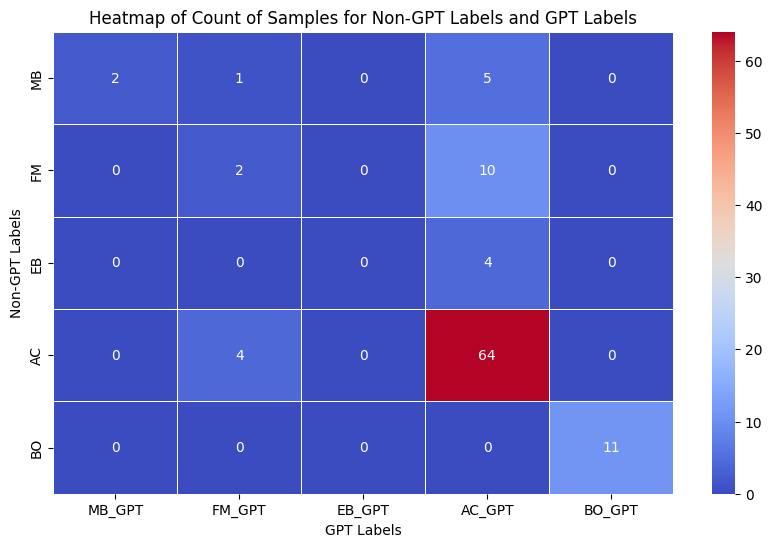

In [6]:
counts_matrix = pd.DataFrame(index=labels, columns=[label + '_GPT' for label in labels])

for label in labels:
    for gpt_label in labels:
        counts_matrix.at[label, gpt_label + '_GPT'] = ((df[label] & df[gpt_label + '_GPT']).sum())

# Convert counts to integer type
counts_matrix = counts_matrix.astype(int)

# Plotting the heatmap with specified axes
plt.figure(figsize=(10, 6))
sns.heatmap(counts_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='d')
plt.title('Heatmap of Count of Samples for Non-GPT Labels and GPT Labels')
plt.xlabel('GPT Labels')
plt.ylabel('Non-GPT Labels')
plt.show()


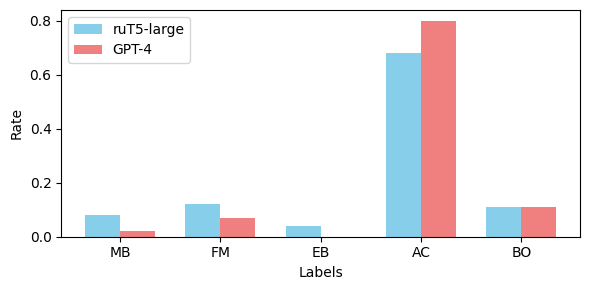

In [7]:
# Calculating the ratio of true values for each non-GPT and GPT column
non_gpt_ratios = df[labels].mean()
gpt_ratios = df[[label + '_GPT' for label in labels]].mean()

# Plotting the ratios
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

ax.bar(x - width/2, non_gpt_ratios, width, label='ruT5-large', color='skyblue')
ax.bar(x + width/2, gpt_ratios, width, label='GPT-4', color='lightcoral')

# Adding labels, title, and legend
ax.set_xlabel('Labels')
ax.set_ylabel('Rate')
# ax.set_title('Mistake rate by type for GPT and ')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()


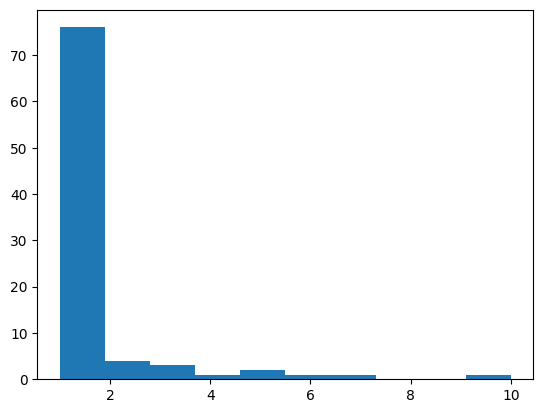

In [8]:
vb_mask = ~df.BO
plt.hist(df[vb_mask]['true bundles']);

## Precision, Recall

In [9]:
df['precision'] = df['correct bundles'] / df['Output'].apply(len)
df['precision_gpt'] = df['correct bundles gpt'] / df['GptOutput'].apply(len)
df['recall'] = df['correct bundles'] / df['true bundles']
df['recall_gpt'] = df['correct bundles gpt'] / df['true bundles']

In [10]:
df.precision.mean(), df.precision_gpt.mean()

(0.7491582491582492, 0.8079999999999999)

In [11]:
df['correct bundles'].sum() / df['Output'].apply(len).sum()

0.7222222222222222

In [12]:
df['correct bundles gpt'].sum() / df['GptOutput'].apply(len).sum()

0.8273381294964028

In [13]:
vb_df = df[vb_mask].copy()

In [14]:
vb_df['correct bundles'].sum() / vb_df['true bundles'].sum()

0.75

In [15]:
vb_df['correct bundles gpt'].sum() / vb_df['true bundles'].sum()

0.8846153846153846

In [37]:
df.recall.mean(), df.recall_gpt.mean()

(0.7348809523809524, 0.8079999999999999)

In [19]:
vb_df.precision.mean(), vb_df.precision_gpt.mean()

(0.8428030303030304, 0.9078651685393259)

In [69]:
vb_df.recall.mean(), vb_df.recall_gpt.mean()

(0.8257089352594971, 0.9078651685393259)

## Price

In [13]:
def try_convert_types(var1, var2):
  type1 = type(var1)
  type2 = type(var2)
  if type1 != type2:
      try:
          var1_to_var2_type = type2(var1)
          return var1_to_var2_type, var2
      except (ValueError, TypeError) as e:
        pass
      try:
          var2_to_var1_type = type1(var2)
          return var1, var2_to_var1_type
      except (ValueError, TypeError) as e:
        pass
  return var1, var2

def process_str(var):
  if isinstance(var, str):
    var = var.strip()
  return var

In [14]:
def price_eq(bundle1, bundle2):
  price1 = bundle1['Price']
  price2 = bundle2['Price']
  price1, price2 = try_convert_types(price1, price2)
  price1 = process_str(price1)
  price2 = process_str(price2)
  return price1 == price2

def first_bundle_apply(row, func, ret_nan=False):
  bundles1 = row['GptOutput']
  bundles2 = row['Output']
  if len(bundles1) != 1 or len(bundles2) != 1:
    return False if not ret_nan else np.nan
  return func(bundles1[0], bundles2[0])
  # return df.apply(lambda row: func(row['GptOutput'], row['Output']), axis=1)

vb_df['price_eq'] = df.apply(lambda row: first_bundle_apply(row, price_eq), axis=1)

In [15]:
vb_df['price_eq']

0      True
1     False
2     False
3     False
5     False
      ...  
95     True
96     True
97     True
98     True
99    False
Name: price_eq, Length: 89, dtype: bool

In [16]:
sb_mask = vb_df['true bundles'] == 1
sb_mask.sum()

76

In [17]:
vb_df[sb_mask & ~vb_df.price_eq][['label gpt', 'label']]

,label gpt,label
2,AC,MB
25,FM,AC
56,AC,FM
75,AC,FM
91,MB,MB


## Currency

In [18]:
currencies = []
for row in pd.concat([train, val_set, manual_test]).itertuples():
  for bundle in row.json:
    currencies.append(bundle['Currency'])
    if bundle['Currency'] =='протеиновый батончик':
      print(row)
currencies = np.unique(currencies)
currencies

Pandas(Index=460, Text='1) Стикеры, подставка для щётки - бесплатно \n2) Мултирезка для овощей - за протеиновый батончик\n3) Доска разделочная пластмассовая - за протеиновый батончик\n4) Точилка для ножей - 2 протеиновых батончика\n5) кружки - по одному батончику. Кружка с Олафом 3 батончика!\n6) питьевая бутылочка - 2 батончика\n7) соль - бесплатно \n410 12-ка', json=[{'Title': 'кружки', 'Price': '1', 'Currency': 'протеиновый батончик', 'Count': '1'}, {'Title': 'Кружка с Олафом', 'Price': '3', 'Currency': 'протеиновый батончик', 'Count': '1'}, {'Title': 'Мултирезка для овощей', 'Price': '1', 'Currency': 'протеиновый батончик', 'Count': '1'}, {'Title': 'питьевая бутылочка', 'Price': '2', 'Currency': 'протеиновый батончик', 'Count': '1'}, {'Title': 'Точилка для ножей', 'Price': '2', 'Currency': 'протеиновый батончик', 'Count': '1'}, {'Title': 'Доска разделочная пластмассовая', 'Price': '1', 'Currency': 'протеиновый батончик', 'Count': '1'}], Label_gpt='valid', n_bundle=6)
Pandas(Index=4

array(['EUR', 'GEL', 'LAR', 'Lari', 'RUB', 'USD', 'eur', 'euro', 'gel',
       'lari', 'грн', 'евр', 'евро', 'л', 'лар', 'лари', 'ларри',
       'протеиновый батончик', 'ლ', '€', '₾'], dtype='<U20')

In [19]:
train.loc[460]

Text         1) Стикеры, подставка для щётки - бесплатно \n...
json         [{'Title': 'кружки', 'Price': '1', 'Currency':...
Label_gpt                                                valid
n_bundle                                                     6
Name: 460, dtype: object

In [20]:
cur_aliases = {
    'EUR': ['eur', 'euro', 'евр', 'евро', '€'],
    'GEL': ['LAR', 'Lari', 'gel', 'lari', 'л', 'лар', 'лари', 'ларри', 'ლ',  '₾'],
    'RUB': ['₽', 'р', 'руб'],
    'USD': ['$'],
    'UAH': ['грн']
  }
for key in cur_aliases.keys():
  cur_aliases[key].append(key)
inverse_currency_aliases = {alias:code for code, aliases in cur_aliases.items() for alias in aliases}

def currency_eq(bundle1, bundle2):
  cur1 = bundle1['Currency'].strip()
  cur2 = bundle2['Currency'].strip()
  if cur1 not in inverse_currency_aliases:
    return False
  else:
    cur1 = inverse_currency_aliases[cur1]
  if cur2 not in inverse_currency_aliases:
    return False
  else:
    cur2 = inverse_currency_aliases[cur2]
  return cur1 == cur2

vb_df['currency_eq'] = df.apply(lambda row: first_bundle_apply(row, currency_eq), axis=1)
vb_df.currency_eq

0      True
1     False
2     False
3     False
5     False
      ...  
95     True
96     True
97     True
98     True
99    False
Name: currency_eq, Length: 89, dtype: bool

In [21]:
vb_df.loc[sb_mask & ~vb_df.currency_eq, ['label', 'label gpt']]

,label,label gpt
2,MB,AC
68,FM,AC
72,AC,FM
76,AC,FM
81,AC,FM


## Count

In [22]:
def count_eq(bundle1, bundle2):
  count1 = bundle1['Count']
  count2 = bundle2['Count']
  count1, count2 = try_convert_types(count1, count2)
  count1 = process_str(count1)
  count2 = process_str(count2)
  return count1 == count2

In [23]:
vb_df['count_eq'] = df.apply(lambda row: first_bundle_apply(row, count_eq), axis=1)
vb_df.count_eq

0      True
1     False
2     False
3     False
5     False
      ...  
95     True
96     True
97     True
98     True
99    False
Name: count_eq, Length: 89, dtype: bool

In [24]:
vb_df.loc[sb_mask & ~vb_df.count_eq, ['label', 'label gpt']]

,label,label gpt
2,MB,AC
25,AC,FM
53,AC,AC
62,FM,AC
68,FM,AC
71,AC,AC
85,FM,AC
87,AC,AC


In [25]:
(df['label gpt'] == 'AC').sum()

80

In [26]:
(df['label'] != 'BO').sum()

89

## Title

In [27]:
import evaluate
bleu_metric = evaluate.load("sacrebleu")

bleu_metric.compute(predictions=['lol'], references=[['lol kek']])['score']

0.0

In [28]:
def title_bleu(bundle1, bundle2):
  return bleu_metric.compute(predictions=[bundle2['Title']], references=[[bundle1['Title']]])['score']

In [29]:
vb_df['title_bleu'] = df.apply(lambda row: first_bundle_apply(row, title_bleu, ret_nan=True), axis=1)
vb_df.title_bleu

0       3.531503
1            NaN
2            NaN
3            NaN
5            NaN
         ...    
95     46.713798
96     53.137469
97    100.000000
98     21.874242
99           NaN
Name: title_bleu, Length: 89, dtype: float64

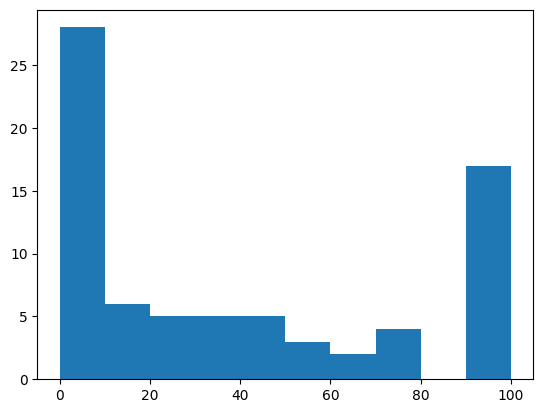

In [30]:
plt.hist(vb_df[sb_mask].title_bleu);

In [31]:
chrf_metric = evaluate.load("chrf")

In [32]:
def title_chrf(bundle1, bundle2):
  return chrf_metric.compute(predictions=[bundle2['Title']], references=[[bundle1['Title']]])['score']

vb_df['title_chrf'] = df.apply(lambda row: first_bundle_apply(row, title_chrf, ret_nan=True), axis=1)
vb_df.title_chrf

0      23.350877
1            NaN
2            NaN
3            NaN
5            NaN
         ...    
95     71.801535
96     71.724683
97    100.000000
98     27.243961
99           NaN
Name: title_chrf, Length: 89, dtype: float64

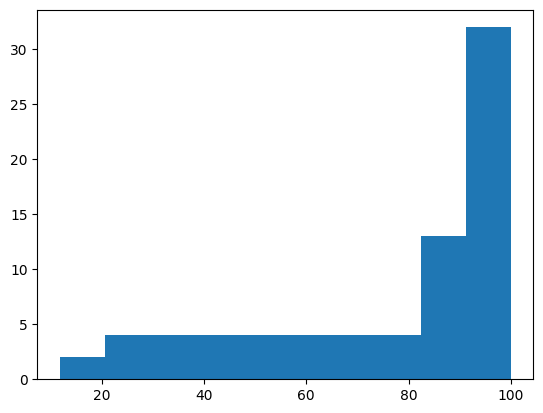

In [33]:
plt.hist(vb_df[sb_mask].title_chrf);

In [34]:
vb_df[vb_df['MB'] & vb_df['AC_GPT']]

,Text,GptOutput,Output,correct bundles gpt,label gpt,correct bundles,label,true bundles,MB_GPT,MB,...,BO,precision,precision_gpt,recall,recall_gpt,price_eq,currency_eq,count_eq,title_bleu,title_chrf
2,#продам ракету cannondale supersix evo 🚀☺️\nкр...,[{'Title': 'Велосипед Cannondale Supersix Evo'...,[],1,AC,0.0,MB,1,False,True,...,False,NaN,1.0,0.000000,1.0,False,False,False,NaN,NaN
3,"- кофеварка капельная, 300р или большая милка....","[{'Title': 'телефон', 'Price': '500', 'Currenc...","[{'Title': ' кофеварка капельная', 'Price': ' ...",7,AC,4.0,"FM,MB,EB",7,False,True,...,False,0.666667,1.0,0.571429,1.0,False,False,False,NaN,NaN
26,"Москва ст. М. Новокосино \nавито доставка , по...","[{'Title': 'Футболка modis чёрная', 'Price': '...",[{'Title': ' Футболка hm унисекс music vibrati...,10,AC,4.0,MB,10,False,True,...,False,1.000000,1.0,0.400000,1.0,False,False,False,NaN,NaN
57,здравствуйте!\nпродам платья (оригинал): \n1. ...,"[{'Title': 'Платье Maje размер 1 (XS-S)', 'Pri...","[{'Title': ' платье maje размер 2 (s-m)', 'Pri...",3,AC,2.0,MB,3,False,True,...,False,1.000000,1.0,0.666667,1.0,False,False,False,NaN,NaN
90,"стаканы для коктейля 1€ за два, бокалы с фести...","[{'Title': 'стопки', 'Price': '1', 'Currency':...","[{'Title': ' стаканы для коктейля', 'Price': '...",4,AC,3.0,"EB,MB",4,False,True,...,False,0.750000,1.0,0.750000,1.0,False,False,False,NaN,NaN


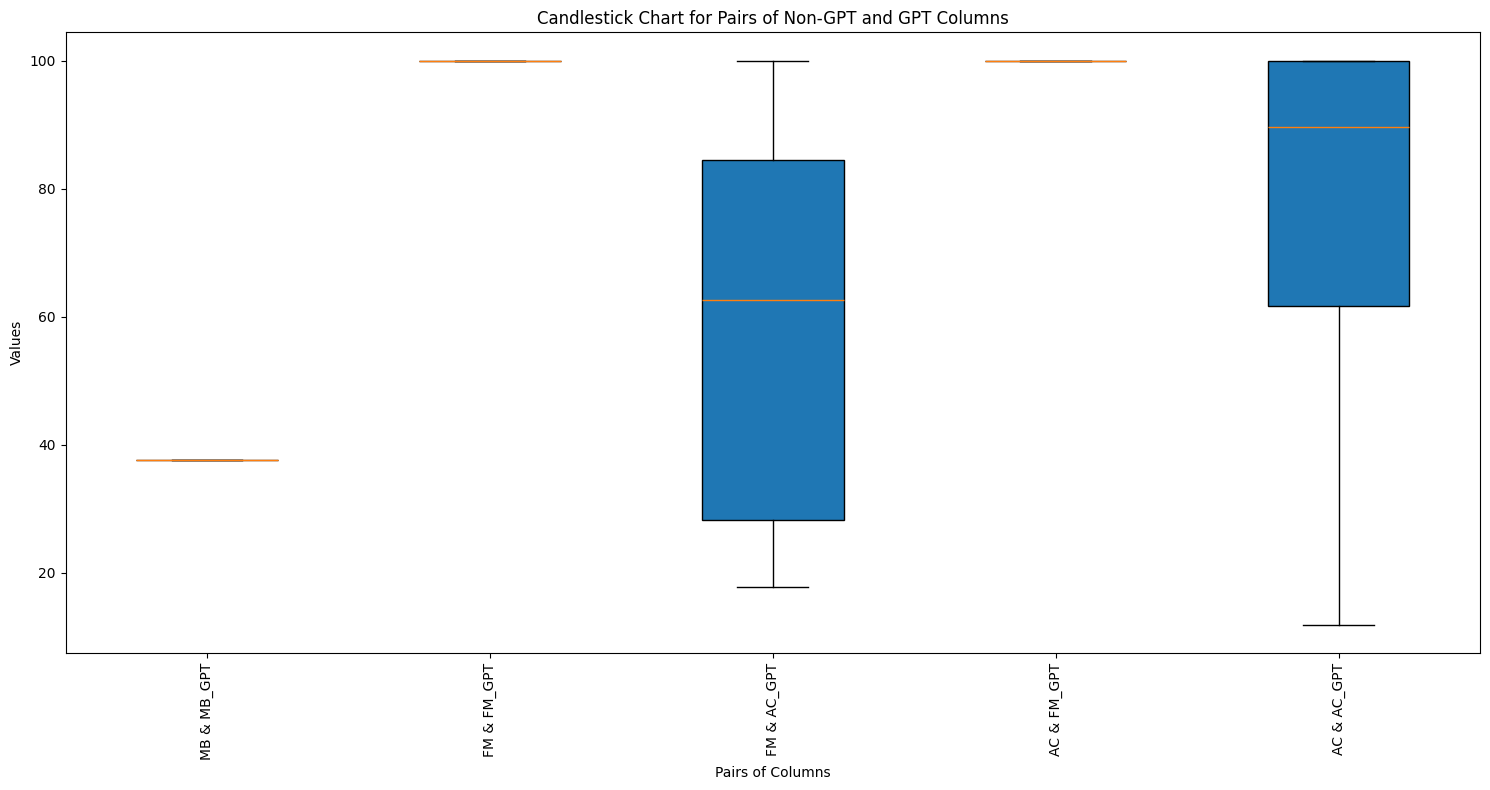

In [35]:
pairs = [(non_gpt_label, gpt_label + '_GPT') for non_gpt_label in labels for gpt_label in labels]
boxplot_data = []

chart_labels = []
for non_gpt_label, gpt_label in pairs:
  filtered_df = vb_df[vb_df[non_gpt_label] & vb_df[gpt_label]]
  vals = [val for val in filtered_df['title_chrf'].values if not np.isnan(val)]
  if len(vals) == 0:
    continue
  chart_labels.append(f'{non_gpt_label} & {gpt_label}')
  boxplot_data.append(vals)

plt.figure(figsize=(15, 8))
plt.boxplot(boxplot_data, labels=chart_labels, patch_artist=True)
plt.xticks(rotation=90)
plt.title('Candlestick Chart for Pairs of Non-GPT and GPT Columns')
plt.xlabel('Pairs of Columns')
plt.ylabel('Values')
plt.tight_layout()
plt.show()


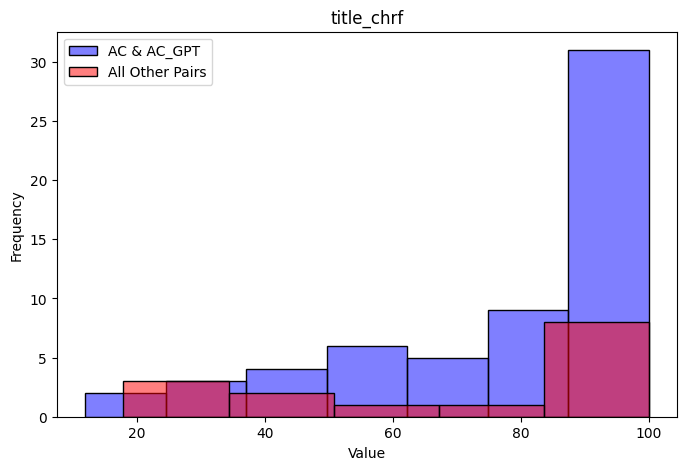

In [36]:
def plot_metric_hist(col_name):
  ac_ac_gpt_data = vb_df[vb_df['AC'] & vb_df['AC_GPT']][col_name]

  all_other_data = vb_df[~(vb_df['AC'] & vb_df['AC_GPT'])][col_name]

  # Plotting the distribution histograms
  plt.figure(figsize=(8, 5))

  # Plot for the ('AC', 'AC_GPT') pair
  sns.histplot(ac_ac_gpt_data, color='blue', label='AC & AC_GPT', alpha=0.5)

  # Plot for all other pairs
  sns.histplot(all_other_data, color='red', label='All Other Pairs', alpha=0.5)

  # Adding titles and labels
  plt.title(col_name)
  plt.xlabel('Value')
  plt.ylabel('Frequency')
  plt.legend()

  plt.show()

plot_metric_hist('title_chrf')

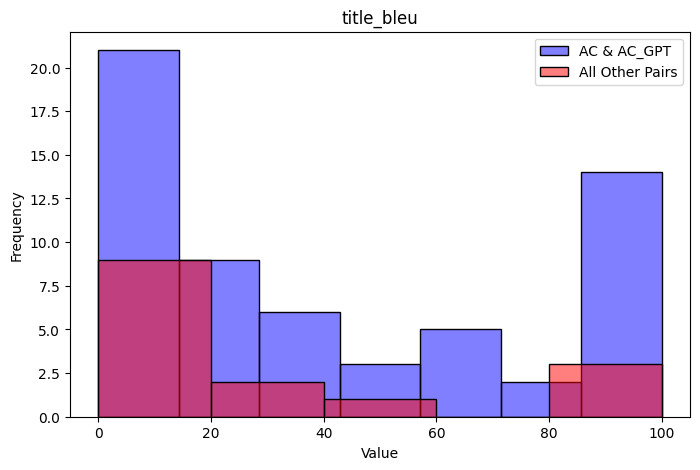

In [37]:
plot_metric_hist('title_bleu')

## full bundle metrics

### wighted sum v1

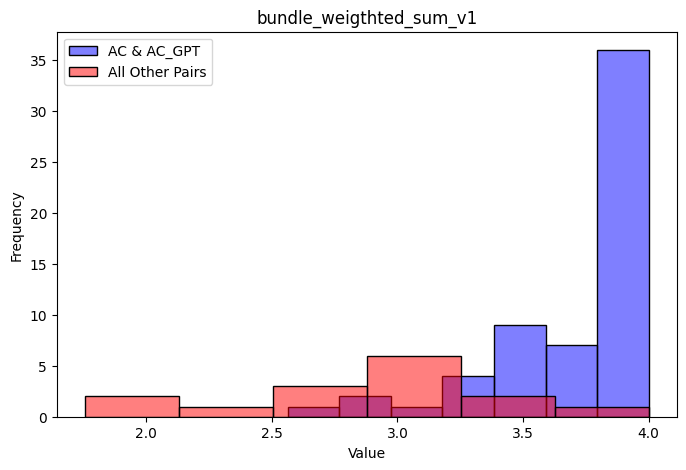

In [38]:
def weighted_sum_v1(bundle1, bundle2):
  res = 0.0
  res += price_eq(bundle1, bundle2)
  res += currency_eq(bundle1, bundle2)
  res += count_eq(bundle1, bundle2)
  res += title_chrf(bundle1, bundle2) / 100
  return res

vb_df['bundle_weigthted_sum_v1'] = df.apply(lambda row: first_bundle_apply(row, weighted_sum_v1, ret_nan=True), axis=1)
plot_metric_hist('bundle_weigthted_sum_v1')

### product

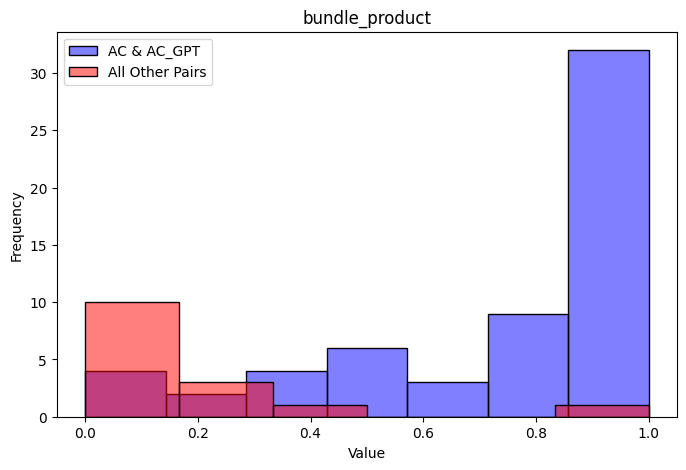

In [39]:
def product(bundle1, bundle2):
  res = 1.0
  res *= price_eq(bundle1, bundle2)
  res *= currency_eq(bundle1, bundle2)
  res *= count_eq(bundle1, bundle2)
  res *= title_chrf(bundle1, bundle2) / 100
  return res

vb_df['bundle_product'] = df.apply(lambda row: first_bundle_apply(row, product, ret_nan=True), axis=1)
plot_metric_hist('bundle_product')

### harmonic

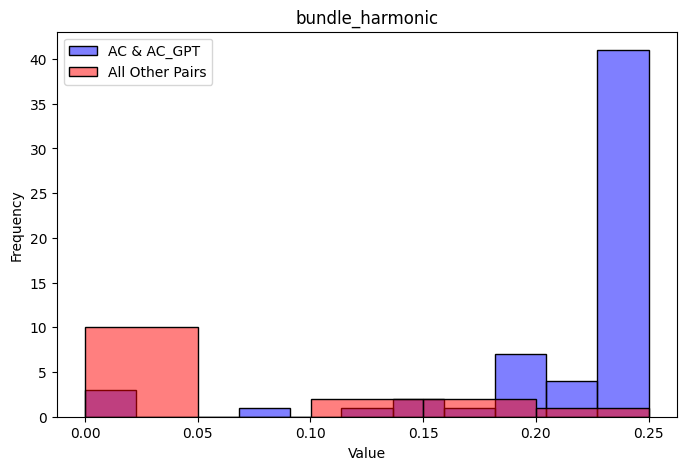

In [40]:
def harmonic(bundle1, bundle2):
  res = 0.0
  res += 1/(1e-4 + price_eq(bundle1, bundle2))
  res += 1/(1e-4 + currency_eq(bundle1, bundle2))
  res += 1/(1e-4 + count_eq(bundle1, bundle2))
  res += 1/(1e-4 + title_chrf(bundle1, bundle2) / 100)
  return 1/res

vb_df['bundle_harmonic'] = df.apply(lambda row: first_bundle_apply(row, harmonic, ret_nan=True), axis=1)
plot_metric_hist('bundle_harmonic')

### weighted sum v2

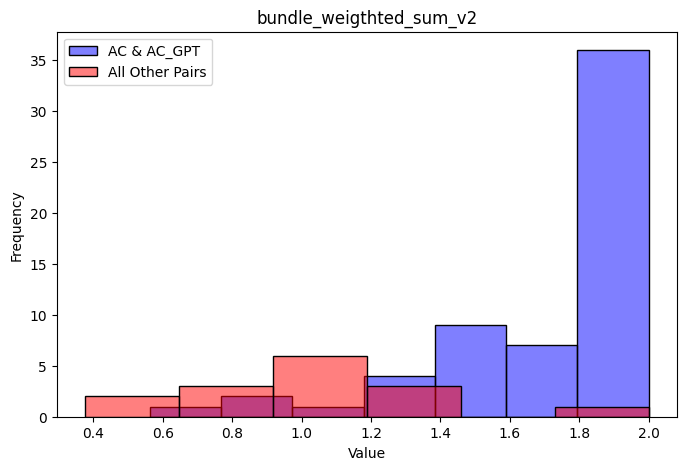

In [41]:
def weighted_sum_v2(bundle1, bundle2):
  res = 1.0
  res *= price_eq(bundle1, bundle2)
  res *= currency_eq(bundle1, bundle2)
  res *= count_eq(bundle1, bundle2)
  res += title_chrf(bundle1, bundle2) / 100
  return res

vb_df['bundle_weigthted_sum_v2'] = df.apply(lambda row: first_bundle_apply(row, weighted_sum_v2, ret_nan=True), axis=1)
plot_metric_hist('bundle_weigthted_sum_v2')

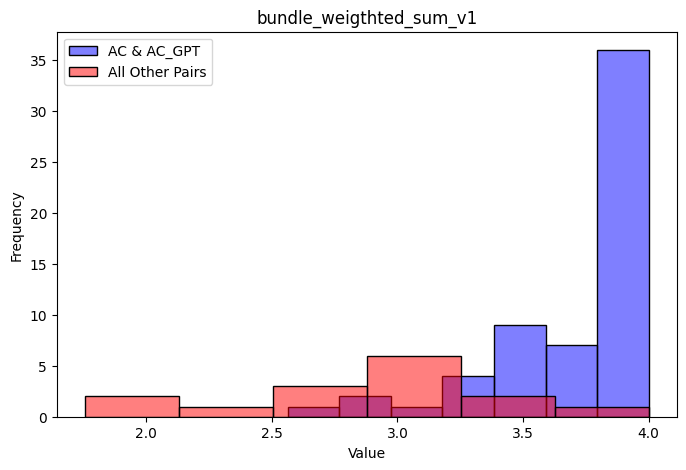

In [42]:
plot_metric_hist('bundle_weigthted_sum_v1')

## Multiple bundle

In [43]:
def best_match_multi_bundle_apply(row, func, ret_nan=False):
  bundles1 = row['GptOutput']
  bundles2 = row['Output']
  ids1 = list(range(len(bundles1)))
  ids2 = list(range(len(bundles2)))
  best_match = []
  scores = []
  while len(ids1) > 0 and len(ids2) > 0:
    pairs = [(i, j) for i in ids1 for j in ids2]
    best_pair = max(pairs, key=lambda pair: func(bundles1[pair[0]], bundles2[pair[1]]))
    ids1 = [i for i in ids1 if i != best_pair[0]]
    ids2 = [i for i in ids2 if i != best_pair[0]]
    best_match.append(best_pair)
    scores = [func(bundles1[pair[0]], bundles2[pair[1]]) for pair in best_match]
  for _ in ids1 + ids2:
    scores.append(0)
  return np.mean(scores)

### w sum v2

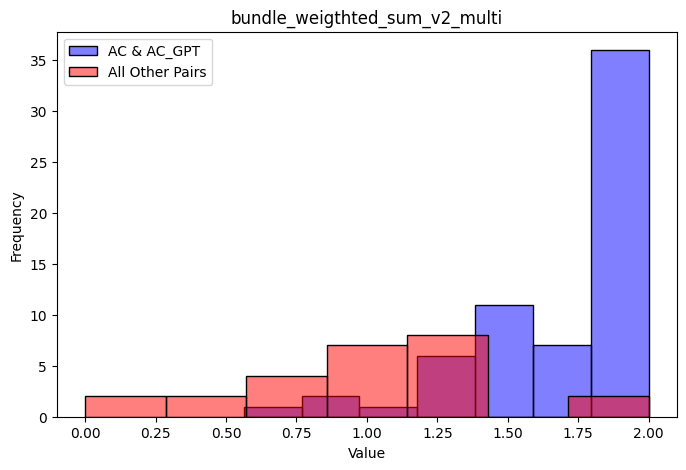

In [44]:
vb_df['bundle_weigthted_sum_v2_multi'] = df.apply(lambda row: best_match_multi_bundle_apply(row, weighted_sum_v2, ret_nan=True), axis=1)
plot_metric_hist('bundle_weigthted_sum_v2_multi')

### w sum v1

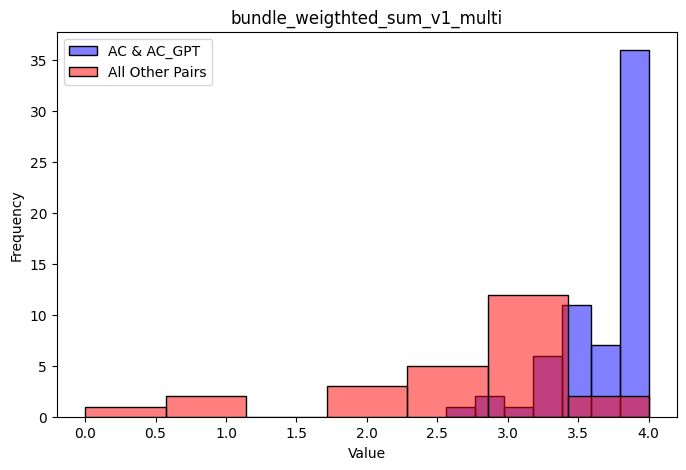

In [45]:
vb_df['bundle_weigthted_sum_v1_multi'] = df.apply(lambda row: best_match_multi_bundle_apply(row, weighted_sum_v1, ret_nan=True), axis=1)
plot_metric_hist('bundle_weigthted_sum_v1_multi')

### product

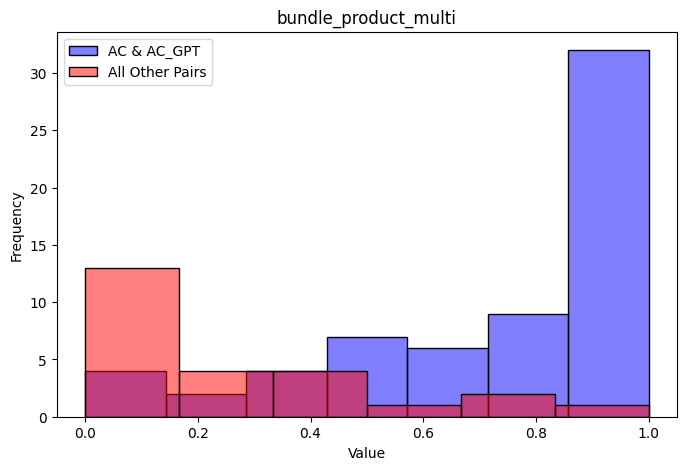

In [46]:
vb_df['bundle_product_multi'] = df.apply(lambda row: best_match_multi_bundle_apply(row, product, ret_nan=True), axis=1)
plot_metric_hist('bundle_product_multi')

### harmonic

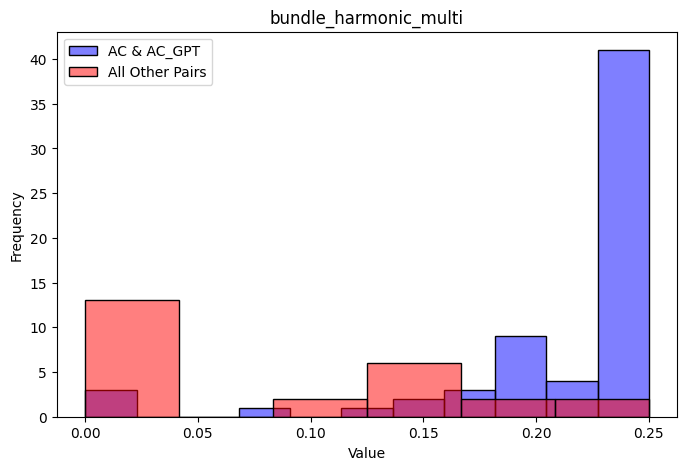

In [47]:
vb_df['bundle_harmonic_multi'] = df.apply(lambda row: best_match_multi_bundle_apply(row, harmonic, ret_nan=True), axis=1)
plot_metric_hist('bundle_harmonic_multi')

### only chrf

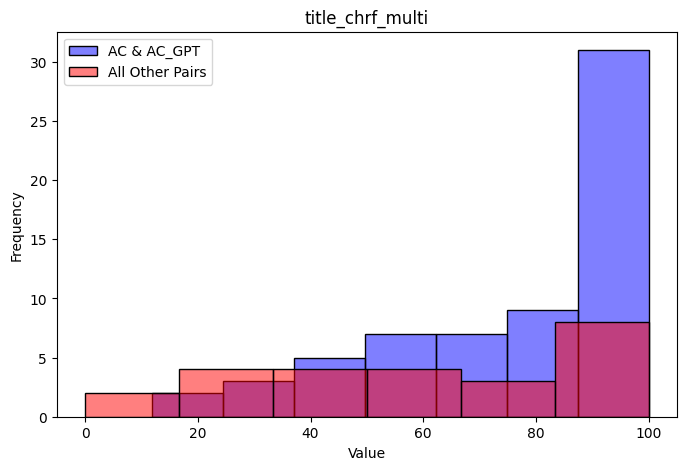

In [48]:
vb_df['title_chrf_multi'] = df.apply(lambda row: best_match_multi_bundle_apply(row, title_chrf, ret_nan=True), axis=1)
plot_metric_hist('title_chrf_multi')

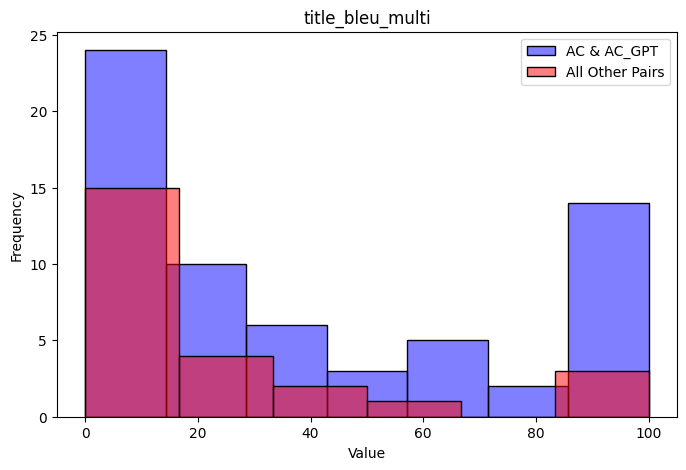

In [49]:
vb_df['title_bleu_multi'] = df.apply(lambda row: best_match_multi_bundle_apply(row, title_bleu, ret_nan=True), axis=1)
plot_metric_hist('title_bleu_multi')

## Mistake indicators

In [50]:
vb_df['EB_ind'] = vb_df.GptOutput.apply(len) < vb_df.Output.apply(len)

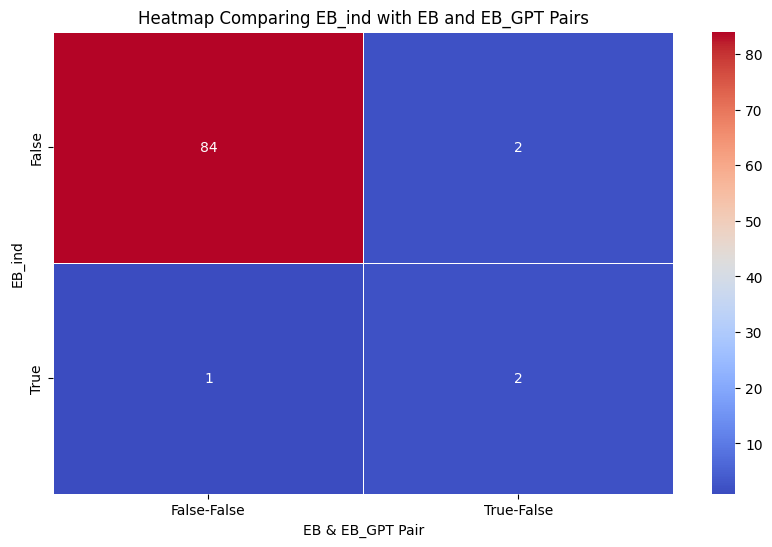

In [51]:
heatmap_data = pd.crosstab(index=vb_df['EB_ind'], columns=[vb_df['EB'], vb_df['EB_GPT']])

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', linewidths=0.5, fmt='d')
plt.title('Heatmap Comparing EB_ind with EB and EB_GPT Pairs')
plt.xlabel('EB & EB_GPT Pair')
plt.ylabel('EB_ind')
plt.show()

In [52]:
vb_df['MB_ind'] = vb_df.GptOutput.apply(len) > vb_df.Output.apply(len)

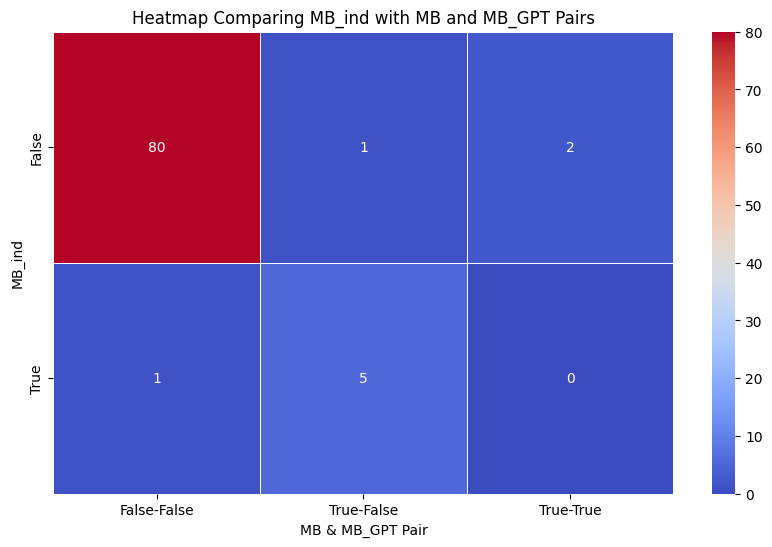

In [53]:
heatmap_data = pd.crosstab(index=vb_df['MB_ind'], columns=[vb_df['MB'], vb_df['MB_GPT']])

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', linewidths=0.5, fmt='d')
plt.title('Heatmap Comparing MB_ind with MB and MB_GPT Pairs')
plt.xlabel('MB & MB_GPT Pair')
plt.ylabel('MB_ind')
plt.show()

In [54]:
df.to_csv('gpt_vs_ruT5-large_manual.csv', index=False)

## final metrics

In [55]:
ls = ['bundle_product_sb', 'bundle_product_multi', 'title_bleu_sb', 'title_chrf_sb', 'title_chrf_multi', 'EB_ind', 'MB_ind', 'fail_rate']

In [56]:
def first_bundle_apply_gen(func, ret_nan=False):
  def wrapped(bundles1, bundles2):
    if len(bundles1) != 1 or len(bundles2) != 1:
      return False if not ret_nan else np.nan
    return func(bundles1[0], bundles2[0])
  return wrapped

def best_match_multi_bundle_apply_gen(func):
  def wrapped(bundles1, bundles2):
    ids1 = list(range(len(bundles1)))
    ids2 = list(range(len(bundles2)))
    best_match = []
    scores = []
    while len(ids1) > 0 and len(ids2) > 0:
      pairs = [(i, j) for i in ids1 for j in ids2]
      best_pair = max(pairs, key=lambda pair: func(bundles1[pair[0]], bundles2[pair[1]]))
      ids1 = [i for i in ids1 if i != best_pair[0]]
      ids2 = [i for i in ids2 if i != best_pair[0]]
      best_match.append(best_pair)
      scores = [func(bundles1[pair[0]], bundles2[pair[1]]) for pair in best_match]
    for _ in ids1 + ids2:
      scores.append(0)
    return np.mean(scores)
  return wrapped

In [57]:
metrics = {
  'BEP-sb': first_bundle_apply_gen(product, ret_nan=True),
  'BEP-multi': best_match_multi_bundle_apply_gen(product),
  'T-BLEU-sb': first_bundle_apply_gen(title_bleu, ret_nan=True),
  'T-CHRF-sb': first_bundle_apply_gen(title_chrf, ret_nan=True),
  'T-CHRF-multi': best_match_multi_bundle_apply_gen(title_chrf),
  'EB-ind': lambda bundles1, bundles2: len(bundles1) < len(bundles2),
  'MB-ind':lambda bundles1, bundles2: len(bundles1) > len(bundles2)
}

def calc_metrics(preds, refs):
  assert len(preds) == len(refs)
  results = {}
  for key, func in metrics.items():
    metric_values = []
    for i in range(len(preds)):
      pred = preds[i]
      ref = refs[i]
      metric_values.append(func(ref, pred))
    metric_values = [val for val in metric_values if val is not np.nan]
    results[key] = np.mean(metric_values)
  return results

In [58]:
refs = [list(bundles) for bundles in df.GptOutput.values]
preds = [list(bundles) for bundles in df.Output.values]

In [59]:
calc_metrics(preds, refs)

{'BEP-sb': 0.6043147583426661,
 'BEP-multi': 0.5705023405201383,
 'T-BLEU-sb': 36.113823409914104,
 'T-CHRF-sb': 73.84116790385943,
 'T-CHRF-multi': 69.62200087813427,
 'EB-ind': 0.04,
 'MB-ind': 0.06}